# Pushing particles (2-D)
Pushing particles around a mesh requires finding a good estimate of the eulerian velocity field on each particle location.

When interpolating onto particle points, we need to know which element each particle is inside of and the barycentric coordinates within that element. As input to such a method, we have 

1. `(xp,yp)` - the longitude and latitude of all particles
2. `(xv,yv,iv)` - mesh vertices and associated indices (also called `nod2d` in FESOM2)
3. `(ev)` - array of size `(1:nelem,1:3)` listing the element to vertex connectivity

To interpolate the mesh information onto the particle positions, we need to be able to identify the element each particle resides within. Once the element ID's are identified, computational coordinates / barycentric weights can be calculated and the `u` and `v` velocity components can be interpolated onto each point. If we are using an explicit time integration scheme, the particles can be advanced to new positions using the interpolated velocity fields. On the subsequent time step, we can check to see if each particle is still within the same element it was last seen in. If a particle is found in the same element, the computational coordinates can be re-calculated; if it is not, then we can search through the element neighbors to identify where the particle has gone to. In general, the algorithm looks like the following

* Initial element search. For each particle, determine the element ID it resides in
* Time loop
  * For each particle, calculate the barycentric weights (input: particle position, particle element IDs, element to vertex mapping )
  * For each particle, interpolate `u` and `v` onto particle positions (input: barycentric weights, particle element IDs, element to vertex mapping, u, v)
  * For each particle, update position
  * For each particle, update element IDs

## Initial element search
For an initial particle distribution, we need to perform a search to determine which element each particle resides in. When searching for the elements in a mesh that particles reside in for interpolation, efficiency and scalability are key. This becomes particularly important when simulating a large number of particles in a high-resolution grid or unstructured mesh. Here are some methods that scale well for finding elements in a mesh:

1. **Direct Grid Indexing (for Structured Grids)** : **\(O(1)\)** 
2. **Bounding Volume Hierarchies (BVH) (for Unstructured Meshes)** : Construction is **\(O(n \log n)\)**, and querying is **\(O(\log n)\)**, making it scalable for large meshes.
3. **KD-Trees (for General Geometries; commonly used in mesh free methods)** : Querying is **\(O(\log n)\)**
4. **Quadtrees** : Querying is **\(O(\log n)\)**
5. **Voronoi Diagrams** : Querying is **\(O(\log n)\)** *if a suitable search structure is employed (e.g., using a Voronoi graph or by combining with KD-tree/BVH structures)*. It’s more computationally expensive set up but can provide fast querying.
6. **Morton/Z-Order Curves (for Space-Filling Curves)** : Querying is **\(O(\log n)\)**; *Morton codes are particularly good for parallelization and GPU-based implementations.*
7. **Spatial Hashing (for Dynamic Particle Systems)** : Querying is **\(O(1)\)**; *Care is needed to avoid collisions and handle edge cases efficiently*

In Particle-In-Cell (PIC) simulations with **unstructured 2D triangular meshes**, determining which mesh element (triangle) a particle resides in is a critical step for accurate interpolation and force computation. **Spatial hashing** can be adapted to accelerate this process, even with the complexity of an unstructured mesh. The main challenge in this case is efficiently searching the large number of mesh elements (triangles) to find the one that contains a given particle, especially as the number of particles increases.

Here’s how spatial hashing can be applied in this context, along with an example.

## Spatial Hashing with an Unstructured 2D Triangular Mesh

1. **Divide the Space into Hash Cells**:
   - Although the underlying mesh is unstructured (i.e., made up of triangles of various shapes and sizes), the overall 2D simulation space can still be divided into a grid of square (or rectangular) **hash cells**. Each hash cell corresponds to a "bucket" in the hash table. Hash cells are typically defined by their lower left corner vertex and the cell size **(\delta x, \delta y)**
   - Each triangle in the unstructured mesh is assigned to one or more hash cells based on its bounding box. This means that each hash cell contains a list of the triangles that overlap with it.

2. **Preprocessing: Assign Triangles to Hash Cells**:
   - For each triangle in the mesh, compute its **axis-aligned bounding box (AABB)**. This is the smallest rectangle that fully encloses the triangle, aligned with the coordinate axes.
   - Using the bounding box, determine which hash cells the triangle overlaps. This might involve checking multiple hash cells (for example, if the triangle spans several cells).
   - Store the triangle’s reference in each of the relevant hash cell buckets in the hash table. A good hash function (as described earlier) is used to map the coordinates of each hash cell to a hash key.

3. **Particle-to-Element Search**:
   - For each particle, compute the hash key of the cell that contains its position.
   - Check all the triangles associated with that hash cell (retrieved from the hash table).
   - For each triangle in the bucket, perform a **point-in-triangle test** to determine if the particle lies inside the triangle.

4. **Point-in-Triangle Test**:
   - For each triangle found in the hash cell, the particle’s position is tested using **barycentric coordinates** or other geometric tests to check whether the particle lies inside the triangle.
   - If the particle lies inside the triangle, it is assigned to that triangle for the purpose of interpolation.

5. **Handling Edge Cases**:
   - If the particle’s position is near a triangle edge or vertex, it may belong to multiple neighboring triangles. In such cases, you may need to apply additional logic to select the triangle or handle interpolation across multiple elements.

In 2D spatial hashing, **hash cells** are typically defined as rectangular or square regions of space. When defining the position of a hash cell, the reference point for computing the hash key can be either:

1. **The hash cell center**, or
2. **One of the four corner nodes** (usually the lower-left corner, but this can be flexible).

## Common Practice: Lower-Left Corner Node
The most common approach is to take **one of the corner nodes** (usually the **lower-left corner**) of the hash cell as the reference point for computing the hash key. This makes the hashing scheme straightforward and easy to compute, especially when working with regularly spaced grids.

### How It Works:
1. **Define the Hash Cell Size**: Suppose each hash cell has a size \(\Delta x \times \Delta y\).
   
2. **Compute the Hash Cell Coordinates**: For a particle at position \((x, y)\), the hash cell it belongs to is determined by calculating the integer coordinates of the hash cell's lower-left corner:
   \[
   i = \left\lfloor \frac{x}{\Delta x} \right\rfloor, \quad j = \left\lfloor \frac{y}{\Delta y} \right\rfloor
   \]
   where \(\left\lfloor \cdot \right\rfloor\) represents the floor function, which rounds down to the nearest integer.
   
3. **Hash Key Computation**: A hash key is then computed based on these integer cell coordinates, often using a hash function like:
   \[
   \text{hash}(i, j) = (i \times p_1) \oplus (j \times p_2) \mod N
   \]
   where \(p_1\) and \(p_2\) are large prime numbers, and \(N\) is the size of the hash table.

By using the lower-left corner as the reference point, the calculation of which cell a particle belongs to is simple, consistent, and unambiguous. This approach is particularly useful when the simulation space is divided into uniform cells, making it easy to map a particle's coordinates directly to the hash cell.

## Alternative Approach: Cell Centers
An alternative but less common approach is to define hash cells based on their **center** points instead of their corner nodes. In this case, the particle's position would be compared to the center of the closest hash cell, and the coordinates of the center would be used in the hash function.

### How It Works:
1. **Define the Hash Cell Centers**: The center of each hash cell is positioned at:
   \[
   x_{\text{center}} = \left( i + 0.5 \right) \Delta x, \quad y_{\text{center}} = \left( j + 0.5 \right) \Delta y
   \]
   
2. **Compute the Nearest Cell Center**: The particle’s position is compared to the nearest cell center, which is determined by:
   \[
   i = \left\lfloor \frac{x}{\Delta x} - 0.5 \right\rfloor, \quad j = \left\lfloor \frac{y}{\Delta y} - 0.5 \right\rfloor
   \]
   
3. **Hash Key Computation**: The hash key is computed similarly based on the cell’s center coordinates.

## Comparison: Corner Nodes vs. Cell Centers
- **Lower-Left Corner Nodes**:
  - Simple and easy to compute.
  - Faster to implement and directly matches the regular grid layout in many simulations.
  - Particularly useful when mesh boundaries and edges align with the grid.
  
- **Cell Centers**:
  - Sometimes useful if your logic is based on distances to the center of cells.
  - However, it requires slightly more complex calculations and may not align as easily with regular grids used in particle-in-cell (PIC) methods.

## Which One to Use?
- **Corner nodes** (particularly the lower-left corner) are the most common choice in spatial hashing for 2D grids because they provide a simple and efficient way to compute the hash keys and directly map a particle's position to a grid cell.
- **Cell centers** are less common and usually come into play in cases where interactions are more naturally defined with respect to distances from the center of a grid cell.

For unstructured meshes (like 2D triangular meshes), **corner node hashing** is generally preferred because it simplifies the mapping between particles and mesh elements, reducing computational overhead.

### Example Walkthrough

Consider an unstructured 2D triangular mesh with triangles of various shapes and sizes, where particles move across the mesh. Here’s an example to illustrate spatial hashing in action.

#### Step 1: Set Up the Hash Table
Suppose the simulation domain is divided into a grid of hash cells, each corresponding to a spatial region in the 2D plane. For simplicity, let's assume we have a grid with cells of size \( \Delta x \times \Delta y \).

|Hash Cell Coordinates| Contains Triangles (IDs)|
|--------------------|-------------------------|
|(0,0)               | [Triangle 1, Triangle 5] |
|(0,1)               | [Triangle 2, Triangle 7] |
|(1,0)               | [Triangle 3, Triangle 6] |
|(1,1)               | [Triangle 4, Triangle 8] |

#### Step 2: Preprocess the Mesh Triangles
For each triangle in the mesh, calculate its bounding box and determine which hash cells it overlaps. For instance:

- **Triangle 1**: Vertices: \((0.1, 0.1)\), \((0.4, 0.2)\), \((0.3, 0.5)\).
    - Bounding box: \([0.1, 0.3]\) in \(x\), \([0.1, 0.5]\) in \(y\).
    - This overlaps with hash cell \((0,0)\).

- **Triangle 2**: Vertices: \((0.4, 0.6)\), \((0.7, 0.7)\), \((0.6, 0.9)\).
    - Bounding box: \([0.4, 0.7]\) in \(x\), \([0.6, 0.9]\) in \(y\).
    - This overlaps with hash cell \((0,1)\).

The hash table is populated with these references, where each cell contains a list of overlapping triangles.

#### Step 3: Particle Search
Suppose a particle is located at position \((0.45, 0.7)\).

1. **Compute Hash Key**:
   - The particle’s position corresponds to hash cell \((0,1)\) based on its coordinates.
   - Using the hash function, retrieve the list of triangles associated with this hash cell. Let’s say the list contains **Triangle 2** and **Triangle 7**.

2. **Point-in-Triangle Test**:
   - Perform a point-in-triangle test for each triangle in the list.
   - For **Triangle 2**, you calculate barycentric coordinates for the particle's position relative to the triangle's vertices.
     - If the barycentric coordinates indicate that the particle is inside Triangle 2, this is the containing element.
   - If not, move on to **Triangle 7** and repeat the test.

3. **Assign the Particle to the Triangle**:
   - If the particle is found to reside in Triangle 2, the particle’s position is associated with Triangle 2, and any necessary interpolation (for fields, charge, etc.) will be performed using the values associated with Triangle 2’s vertices.

#### Step 4: Rehashing for Particle Motion
As particles move across the mesh, they may cross into new hash cells. After each simulation time step, rehash particles based on their new positions, and repeat the process to determine their new containing triangles.

### Benefits of Spatial Hashing in PIC with Unstructured Meshes

1. **Efficiency**: Without spatial hashing, determining the triangle that contains a particle in an unstructured mesh would involve checking every triangle, resulting in a complexity of **\(O(n)\)** per particle, where \(n\) is the number of triangles. Spatial hashing reduces this search to **\(O(1)\)** on average, significantly speeding up the simulation.
   
2. **Scalability**: By mapping the 2D simulation space to a grid, spatial hashing allows for fast querying and efficient handling of large numbers of particles in large meshes, which scales well as the mesh resolution increases.

3. **Parallelization**: The hash table construction and particle search process can be parallelized, allowing for efficient execution on multi-core processors or GPUs.

### Challenges

1. **Hash Cell Size**: Choosing an appropriate cell size is important. Cells that are too large may result in many triangles per cell, slowing down the search. Cells that are too small may increase the number of hash cells a triangle overlaps with, making the hash table more memory-intensive.
   
2. **Edge Cases**: Particles near triangle edges or vertices may require additional checks to handle ambiguity in determining the containing element.

Choosing the hash cell size for spatial hashing in an unstructured triangular mesh involves balancing between performance and accuracy. Here are some key considerations and strategies to help you select an appropriate hash cell size:

### Key Considerations for Hash Cell Size

1. **Triangle Size and Distribution**:
   - The hash cell size should be roughly comparable to the size of the triangles in the mesh. Since the mesh is unstructured, triangle sizes might vary, so an average or representative triangle size is often used.
   - If there is a significant variation in triangle sizes, you might consider an approach that adjusts hash cell sizes locally or opts for a smaller size to handle smaller triangles effectively.

2. **Particle Density and Movement**:
   - If the particles are densely packed and move only within a small area, you can use smaller hash cells, which will provide more localized results and reduce the number of triangles to check within each cell.
   - If particles move freely across the mesh, a larger hash cell size might be necessary to reduce the likelihood of particles frequently crossing cell boundaries and needing rehashing.

3. **Aspect Ratio of the Mesh**:
   - Triangular meshes might not be uniform, and the aspect ratio could vary in different areas. If triangles are elongated in one direction, consider orienting the hash cells to match the general orientation of triangles, though this adds complexity to the implementation.

### Strategies for Determining Hash Cell Size

1. **Using the Average Triangle Edge Length**:
   - Calculate the average length of all triangle edges in the mesh. This gives a sense of the general triangle size and can be a starting point for the hash cell size.
   - A common heuristic is to set the cell size to be **slightly larger than the average edge length**, which ensures that most triangles will fit within one or two hash cells.

2. **Using the Median Triangle Area**:
   - Compute the area of each triangle and take the median area to avoid being skewed by extremely large or small triangles. 
   - Convert the median area into an approximate length by assuming an equilateral triangle:
     \[
     \text{edge length} \approx \sqrt{\frac{4 \times \text{median area}}{\sqrt{3}}}
     \]
   - Use this length or a slightly larger value as the cell size.

3. **Trial and Error**:
   - Start with a cell size equal to the average triangle edge length, then incrementally adjust it based on performance. You can reduce the size if many hash cells contain numerous triangles, or increase it if too few cells contain multiple triangles.

4. **Bounding Box of Triangles**:
   - For each triangle, calculate its bounding box dimensions. Use an average or representative bounding box diagonal as a basis for the hash cell size. This approach can accommodate irregularly shaped triangles more effectively than edge length alone.

### Example Calculation for Hash Cell Size

Suppose you have a triangular mesh, and the average edge length of the triangles is approximately \( l \). As a rule of thumb, you might start with a hash cell size:
\[
\Delta x = \Delta y \approx 1.5 \times l
\]
This approach assumes that most triangles will fit within a cell or intersect only a few neighboring cells, which keeps the number of checks per particle low.

Alternatively, if the average triangle area is \( A \), you could approximate an equivalent side length as follows:
\[
l_{\text{equiv}} = \sqrt{\frac{4A}{\sqrt{3}}}
\]
Then set the cell size to:
\[
\Delta x = \Delta y \approx 1.5 \times l_{\text{equiv}}
\]

### Evaluating the Cell Size Choice

- **Profile Performance**: After selecting an initial cell size, evaluate the hashing performance by measuring the average number of triangles per hash cell and the frequency of particle rehashing.
- **Adjust Based on Hashing Results**: If hash cells often contain many triangles, reduce the cell size. If cells are mostly empty, increase the size to avoid unnecessary memory usage.

Selecting the right hash cell size will involve some tuning specific to your mesh's characteristics, but using these strategies should give you a practical starting point.

### Example Walkthrough - FESOM2 soufflet with spatial hashing

In this example, we walk through the use of spatial hashing to locate the elements that a set of particles reside in.

#### Reading in the mesh


In [ ]:
! git clone https://github.com/FESOM/fesom2 ./fesom2

In [1]:
# Define the function used for reading in the FESOM2 ASCII mesh files
# From an email exchange with Nikolay Kuldonov (nikolay.koldunov@awi.de)
def load_ascii_mesh(mesh_path):
    """
    Loads the mesh data from the specified path and returns the node coordinates and element connectivity.
    FESOM specific function.

    Args:
        mesh_path (str): The path to the directory containing the model output.

    Returns:
        xr.Dataset: Dataset containing the x-coordinates, y-coordinates, and element connectivity array.

    """
    import pandas as pd
    import numpy as np
    import xarray as xr
    
    nodes = pd.read_csv(
        mesh_path + "/nod2d.out",
        sep="\\s+",
        skiprows=1,
        names=["node_number", "x", "y", "flag"],
    )

    x2 = nodes.x.values
    y2 = nodes.y.values

    file_content = pd.read_csv(
        mesh_path + "/elem2d.out",
        sep="\\s+",
        skiprows=1,
        names=["first_elem", "second_elem", "third_elem"],
    )

    x2 = np.where(x2 > 180, x2 - 360, x2)

    elem = file_content.values - 1

    ds = xr.Dataset(
        {
            "x": (("nod2"), x2),
            "y": (("nod2"), y2),
            "elements": (("elem", "n3"), elem),
        }
    )

    return ds

In [2]:
# Load the mesh

mesh_ds = load_ascii_mesh( "./fesom2/test/meshes/soufflet/")


#### Creating the hash cells
Now we want to create the hash cells for spatial hashing. To do this, we need to define a bounding box for the domain and determine hash cell size. To start, we will look at using a function to calculate the hash cell size using an average of the bounding box diagonal lenght for the triangles in the mesh.

When calculating the diagonals, we need to be careful about periodic domains. The element connectivity is specified to include periodic boundary conditions. This can cause problems with bounding box diagonal calculation or edge length calculation. For example, in an x-periodic domain, elements with vertices on the left most edge of the domain will be connected to elements with vertices on the right most edge of the domain. For these elements, the edge lengths will span the length of the domain, which can artifically increase our measure of the bounding box diagonal length. To avoid this, we use the median bounding box diagonal, rather than the mean to determine the representative size of the hash cells.

**Note** 
Ultimately, we will want to pre-process any mesh that has periodicity. Specicifically, we will need to set up ghost-vertices on the mesh perimeter, connect elements that have periodicity to the ghost vertices, and re-index with the ghost vertices added. From here, we would need a way to also track a "parent-child" relationship between the ghost and original vertices. 

For now, we'll purge these elements from the mesh.


In [55]:
def purge_periodic_elements(vertices, elements, fac=1.0):
    """
    Creates a new list of elements by removing elements that are on periodic boundaries
    
    Parameters:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    
    Returns:
    - cell_size (float): The recommended hash cell size.
    """
    # Initialize a list to store bounding box diagonals
    diagonals = np.zeros(elements.shape[0])

    # Loop over each triangle element
    k = 0
    for triangle in elements:
        # Get the coordinates of the triangle's vertices
        triangle_vertices = vertices[triangle]
        
        # Calculate the bounding box of the triangle
        x_min, y_min = np.min(triangle_vertices, axis=0)
        x_max, y_max = np.max(triangle_vertices, axis=0)
        
        # Calculate the diagonal length of the bounding box
        diagonal = np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2)
        
        # Store the diagonal length
        diagonals[k] = diagonal

        k+=1

    median_diag = np.median(diagonals)
    print(f"median diag : {median_diag}")
    n_new_elements = np.sum((diagonals < fac*median_diag))
    new_elements = np.zeros((n_new_elements,3),dtype=int)
    k = 0
    j = 0
    for triangle in elements:
        if diagonals[k] < fac*median_diag :
            new_elements[j,:] = triangle
            j+=1
        k+=1
        

    return new_elements

import numpy as np

x_v = mesh_ds.x.to_numpy()
y_v = mesh_ds.y.to_numpy()
elements = mesh_ds.elements.to_numpy()

nelems_initial = elements.shape[0]
# Calculate hash cell size
vertices = np.column_stack((x_v,y_v))
elems = purge_periodic_elements(vertices,elements,fac=1.2)
nelems_new = elems.shape[0]

print(f"Removed {nelems_initial - nelems_new} elements from mesh for periodicity")
print(f"Number of elements : {nelems_new}")


median diag : 0.23891506859133
Removed 228 elements from mesh for periodicity
Number of elements : 5472


In [59]:
def calculate_hash_cell_size(vertices, elements, scalefac=1.0):
    """
    Calculate the hash cell size based on the median bounding box diagonal length of all triangles in the mesh.
    
    Parameters:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    
    Returns:
    - cell_size (float): The recommended hash cell size.
    """
    # Initialize a list to store bounding box diagonals
    diagonals = np.zeros(elements.shape[0])

    # Loop over each triangle element
    k = 0
    for triangle in elements:
        # Get the coordinates of the triangle's vertices
        triangle_vertices = vertices[triangle]
        
        # Calculate the bounding box of the triangle
        x_min, y_min = np.min(triangle_vertices, axis=0)
        x_max, y_max = np.max(triangle_vertices, axis=0)
        
        # Calculate the diagonal length of the bounding box
        diagonal = np.sqrt((x_max - x_min) ** 2 + (y_max - y_min) ** 2)*scalefac
        
        # Store the diagonal length
        diagonals[k] = diagonal

        k+=1
    
    # Calculate the average diagonal length
    average_diagonal = np.mean(diagonals)
    print(f"Minimum diagonal : {np.min(diagonals)}")
    print(f"Maximum diagonal : {np.max(diagonals)}")
    print(f"Mean diagonal    : {np.mean(diagonals)}")
    print(f"Median diagonal  : {np.median(diagonals)}")
    
    # Use the average diagonal as a basis for the cell size
    cell_size = np.median(diagonals)
    
    return cell_size

import numpy as np

# Calculate hash cell size
hash_cell_size = calculate_hash_cell_size(vertices, elems, 0.25)
print( f"Hash cell size : {hash_cell_size}")


Minimum diagonal : 0.05971233122228601
Maximum diagonal : 0.05972876714783321
Mean diagonal    : 0.059722279282485254
Median diagonal  : 0.05972876714783249
Hash cell size : 0.05972876714783249


#### Relating the the unstructured mesh elements to the hash cells
Now that we have the hash cell size, we now want to create a lookup table where we can put in the hash cell indices `(i,j)` and retrieve a list of elements whose bounding boxes overlap the hash cells. This way, when we want to map the particle positions to the triangular element id's we can first do a fast lookup against the hash cells. Once we have the hash cell id for the particle position, we can get a short list of triangles that we can use to check if the particle resides in.

The hash cells are defined by their lower left corner and their size. Here, we are assuming the hash cells are squares. To create the hash cells, we first define the bounding box of the domain spanned by the unstructured mesh. 



In [60]:
def get_triangles_in_hash_cells(nxh, nyh, vertices, elements, cell_size):
    """
    Efficiently find the list of triangles whose bounding box overlaps with the specified hash cells.
    
    Parameters:
    - nxh (int) : The number of hash cell vertices in the x-direction
    - nyh (int) : The number of hash cell vertices in the y-direction
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    
    Returns:
    - overlapping_triangles (dict): A dictionary where keys are hash cell coordinates (i, j) and values are lists of triangle indices.
    """
    import numpy as np
    
    overlapping_triangles = [[] for i in range(nxh*nyh)]
    
    # Loop over each triangle element
    for triangle_idx, triangle in enumerate(elements):
        # Get the coordinates of the triangle's vertices
        triangle_vertices = vertices[triangle]
        
        # Calculate the bounding box of the triangle
        x_min, y_min = np.min(triangle_vertices, axis=0)
        x_max, y_max = np.max(triangle_vertices, axis=0)
        
        # Find the hash cell range that overlaps with the triangle's bounding box
        i_min = int(np.floor(x_min / cell_size))
        i_max = int(np.floor(x_max / cell_size))
        j_min = int(np.floor(y_min / cell_size))
        j_max = int(np.floor(y_max / cell_size))
        
        # Iterate over all hash cells that intersect the bounding box
        for j in range(j_min, j_max + 1):
            for i in range(i_min, i_max + 1):
                overlapping_triangles[i+nxh*j].append(triangle_idx)
                    
    return overlapping_triangles

# Get the bounding box for the domain
x_min, y_min = np.min(vertices, axis=0)
x_max, y_max = np.max(vertices, axis=0)

# To determine how many hash cells we need, we divide the domain length by the hash_cell_size
Lx = (x_max-x_min)
Ly = (y_max-y_min)
print( f"Domain size (Lx,Ly) : ({Lx},{Ly})")
nxh = int(np.ceil(Lx/hash_cell_size))
nyh = int(np.ceil(Ly/hash_cell_size))
print( f"Number of hash cells (nxh,nyh) : ({nxh},{nyh})")

# The vertices are required to share an origin in the lower left corner with the hash map.
# Since the hash map is assumed to start at (0,0), then the vertices are translated so that
# the (x_min,y_min) = (0,0)
vertices[:,0] = vertices[:,0] - x_min
vertices[:,1] = vertices[:,1] - y_min
print(f"Check min vertex position : {np.min(vertices, axis=0)}")

triangles_hashmap = get_triangles_in_hash_cells(nxh,nyh,vertices,elems,hash_cell_size)
#print(triangles_hashmap)
hashmap_triangle_count = np.zeros(len(triangles_hashmap))
k=0
for t in triangles_hashmap:
    hashmap_triangle_count[k]=len(t)
    k+=1

nnonzero = np.count_nonzero(hashmap_triangle_count)
print(f"Minimum triangle count per hash cell : {np.min(hashmap_triangle_count)}")
print(f"Maximum triangle count per hash cell : {np.max(hashmap_triangle_count)}")
print(f"Median triangle count per hash cell  : {np.median(hashmap_triangle_count)}")
print(f"Number of non-empty hash cells       : {nnonzero} ( {nnonzero/len(triangles_hashmap)*100.0} %)")
    

Domain size (Lx,Ly) : (4.41,17.9049)
Number of hash cells (nxh,nyh) : (74,300)
Check min vertex position : [0. 0.]
Minimum triangle count per hash cell : 1.0
Maximum triangle count per hash cell : 6.0
Median triangle count per hash cell  : 3.0
Number of non-empty hash cells       : 22200 ( 100.0 %)


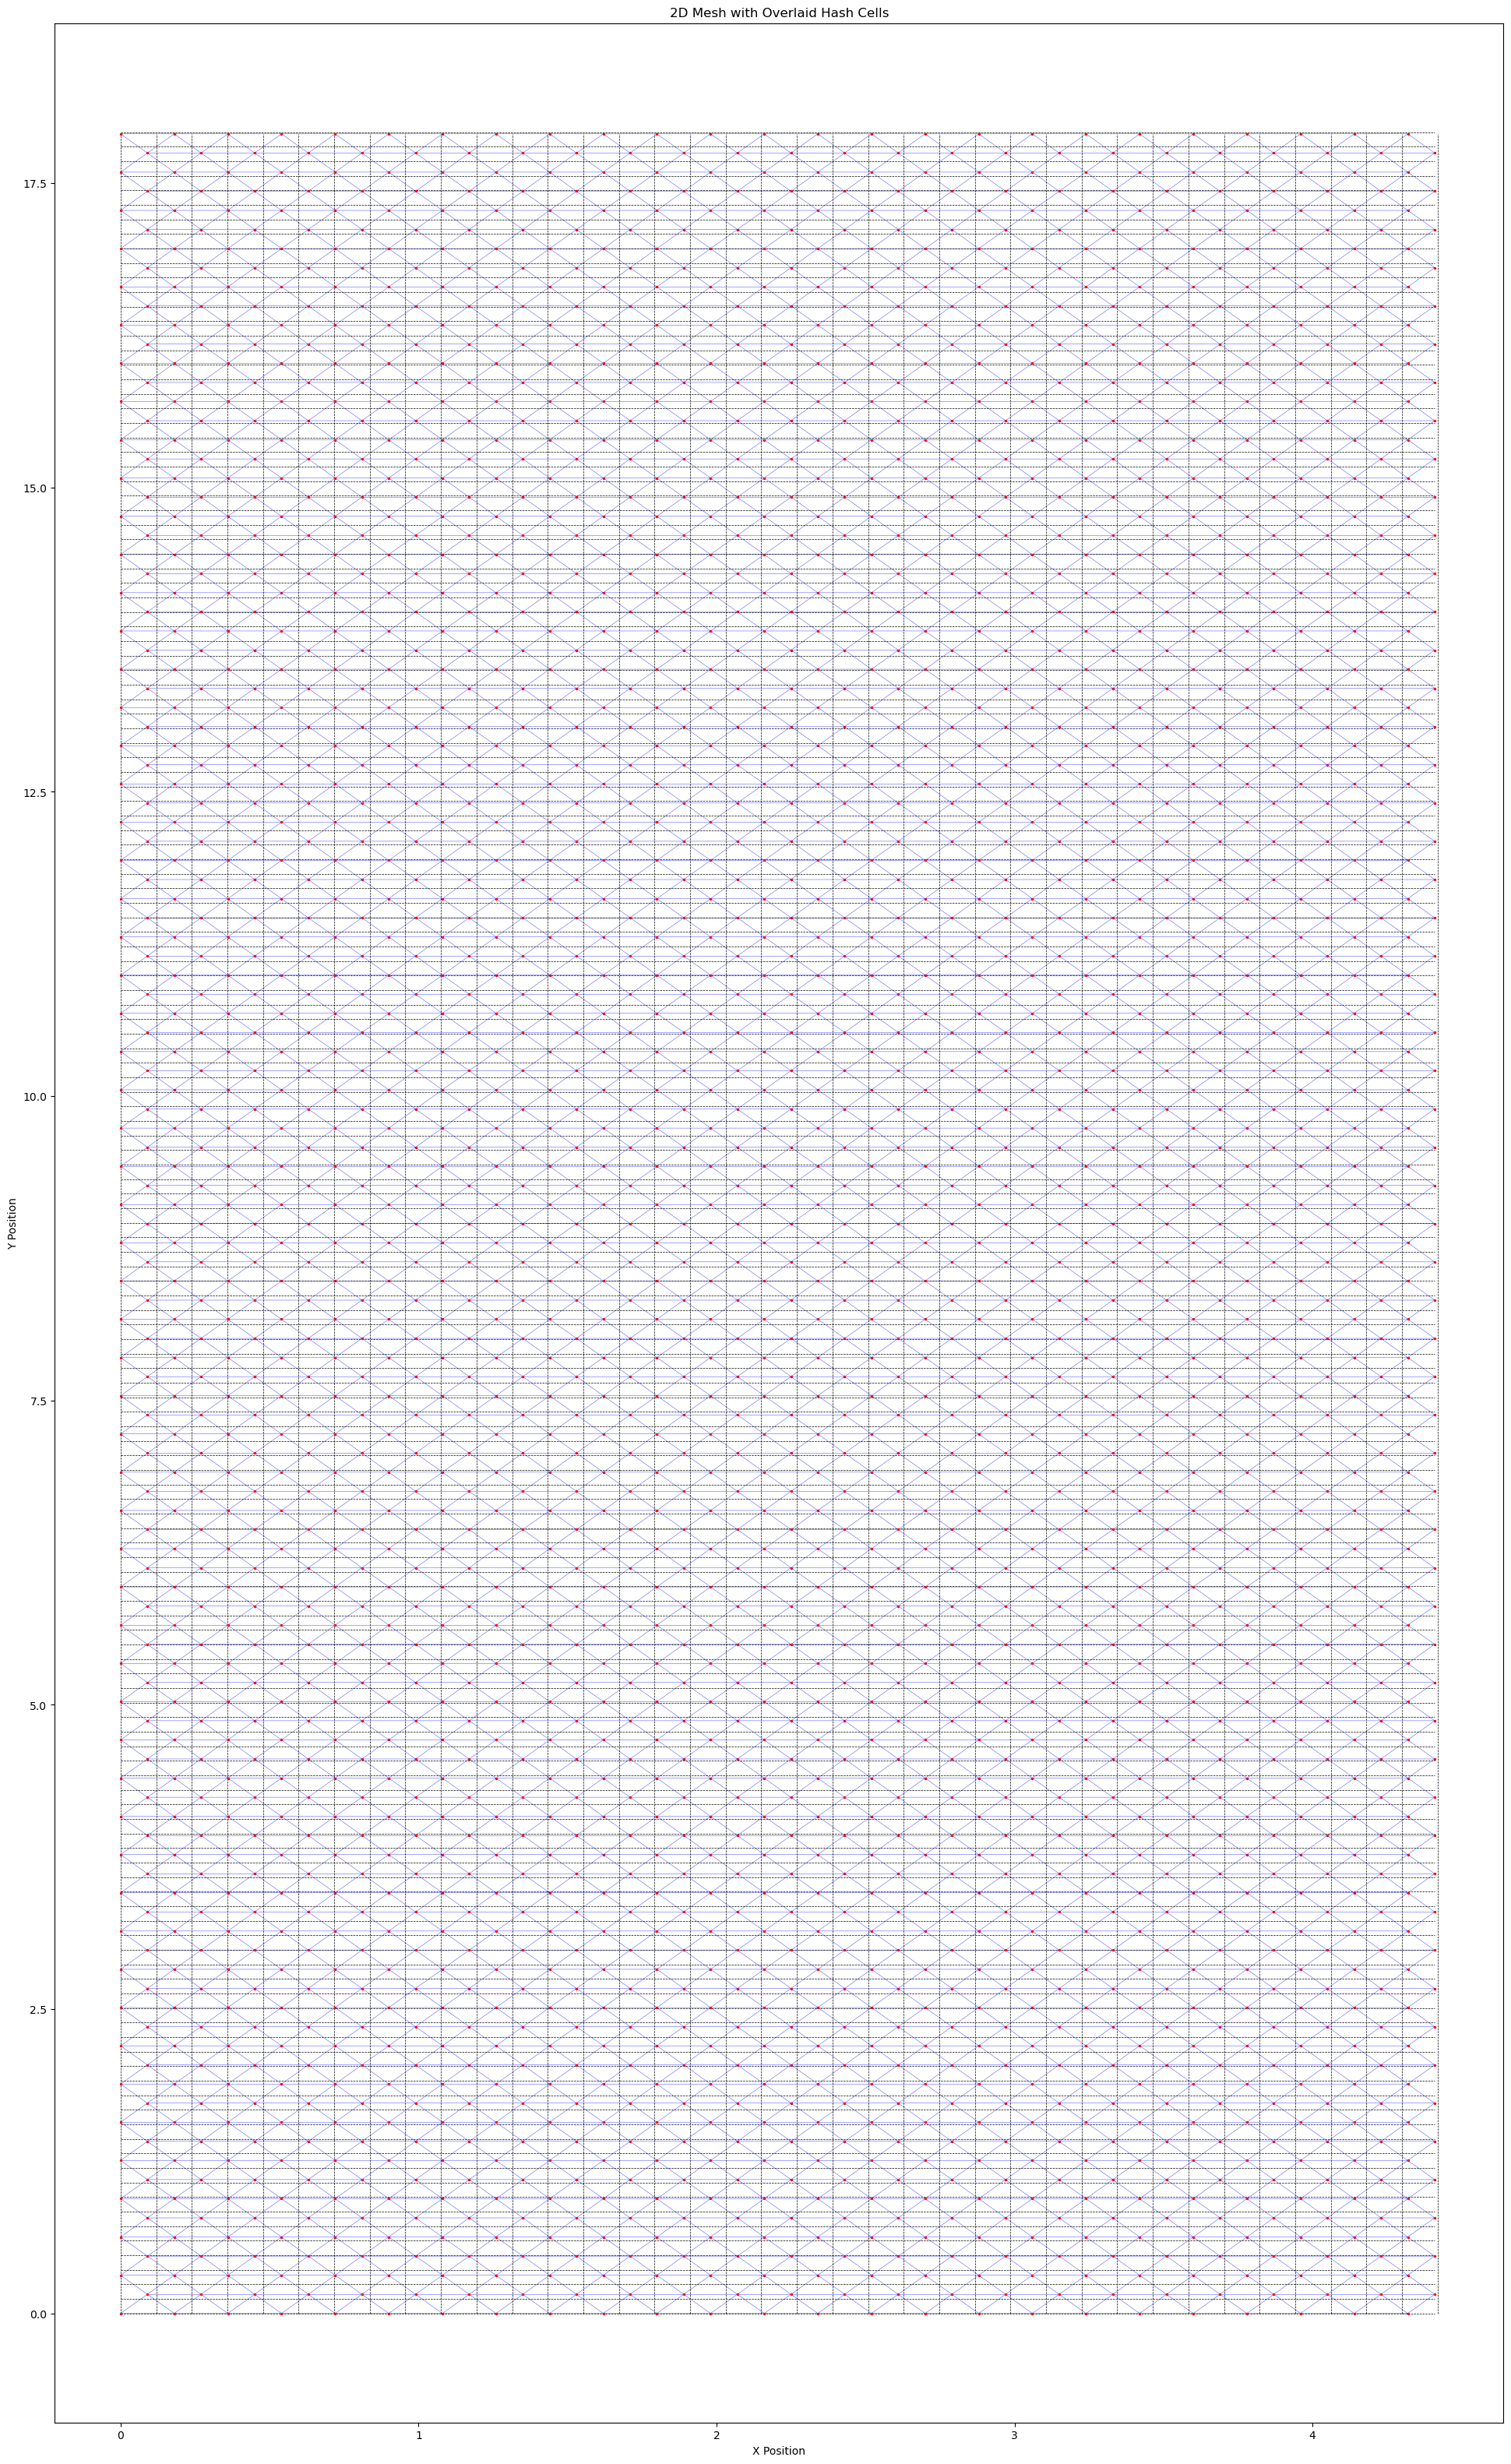

In [58]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.tri as tri

def plot_mesh_with_hash_cells(vertices, elements, cell_size):
    """
    Plots the unstructured mesh with overlaid hash cells.
    
    Parameters:
    - vertices (np.ndarray): Array of vertex coordinates of shape (n_vertices, 2).
    - elements (np.ndarray): Array of element-to-vertex connectivity, where each row contains 3 indices into the vertices array.
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    """
    # Create a matplotlib Triangulation object for the mesh
    mesh = tri.Triangulation(vertices[:, 0], vertices[:, 1], elements)

    # Plot the mesh
    plt.figure(figsize=(24, 40))
    plt.triplot(mesh, color='blue', lw=0.25)
    plt.scatter(vertices[:, 0], vertices[:, 1], color='red', zorder=5, s=2)

    # Get the bounds of the mesh
    x_min, y_min = np.min(vertices, axis=0)
    x_max, y_max = np.max(vertices, axis=0)

    # Generate and plot hash cells
    x_ticks = np.arange(x_min, x_max + cell_size, cell_size)
    y_ticks = np.arange(y_min, y_max + cell_size, cell_size)

    # Plot horizontal lines for hash cells
    for y in y_ticks:
        plt.plot([x_min, x_max], [y, y], color='black', linestyle='--', lw=0.5)

    # Plot vertical lines for hash cells
    for x in x_ticks:
        plt.plot([x, x], [y_min, y_max], color='black', linestyle='--', lw=0.5)

    # # Annotate the hash cells (optional, could be cluttered with dense grids)
    # for i, x in enumerate(x_ticks[:-1]):
    #     for j, y in enumerate(y_ticks[:-1]):
    #         plt.text(x + 0.5 * cell_size, y + 0.5 * cell_size, f"({i},{j})", 
    #                  fontsize=8, color='green', ha='center', va='center', zorder=10)

    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('2D Mesh with Overlaid Hash Cells')
    #plt.gca().set_aspect('equal')
    plt.grid(False)
    plt.show()

# Plot the mesh with hash cells
plot_mesh_with_hash_cells(vertices, elems, hash_cell_size)


#### Aligning the particles with a hash cell
Now that we have the hash map defined and we have associated a list of triangle elements with each hash cell, we can now start working on the search method to map a particle position to an element. The first step in this process is to map the particle position to the hash cell.



In [ ]:
def get_particles_in_hash_cells(nxh, nyh, xp, yp, cell_size):
    """
    Efficiently map the particle positions to the hash
    
    Parameters:
    - nxh (int) : The number of hash cell vertices in the x-direction
    - nyh (int) : The number of hash cell vertices in the y-direction
    - xp (np.ndarray): Array of x component of the particle positions (length = np)
    - yp (np.ndarray): Array of y component of the particle positions (length = np)
    - cell_size (float): The size of each hash cell (assumed square, with width and height equal to cell_size).
    
    Returns:
    - particle_hash (np.ndarray(dtype=int)): Array of size (np) that stores the hash cell index for the particles
    """
    import numpy as np
    
    particle_hash = np.zeros(xp.size[0],dtype=int)

    for k in range(xp.size[0]):
        i = int(np.floor(xp[k] / cell_size))
        j = int(np.floor(yp[k] / cell_size))
        particle_hash[k] = i+nxh*j
        
    return particle_hash

# Seed some particle positions
np = 20

## Left off here!